## ***Jupyter Notebook to accompany the paper:***
    
# ***Embracing uncertainty to resolve polar wander: a North American case study***

### ***by L. C. Gallo$^1$*** *(len.gallo@gmail.com)****, M. Domeier$^1$, F. Sapienza$^2$, N. Swanson-Hysell$^3$, B. Vaes$^4$, G. Shephard$^1$, T. Rolf$^1$, D. Gürer$^5$,  B. Robert, M. Arnaould, A. Kiraly, A. Eyster,  A. van der Boon,  L. Wu, Y. Zhang,***

*(1) Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*

*(2) Department of Statistics, University of California Berkeley, United States.*

*(3) Department of Earth and Planetary Science, University of California, Berkeley, California*

*(4) Department of Earth Sciences, Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands.*

*(5)Research School of Earth Sciences, Australian National University, Canberra, Australian Capital Territory, Australia.*

*()Laboratoire de Géologie de Lyon - Terre, Planètes, Environnement, University Lyon 1 Claude Bernard, Lyon, France*

# Figure 1 - Compile data notebook

This notebook iterates through each paleomagnetic record (datasheet) of the vgp database, extracts data meeting user-specified criteria, and appends them to a new dataframe for later processing (to generate an APWP).

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
from tqdm import tqdm

from vgptools.utils import (get_files_in_directory)

from vgptools.utils_compilation import (split_datasheet, recalc_vgps, go_reverse, get_alpha95, get_k, get_ages)

                                        # (generates_compilation, split_datasheet,
                                        # recalc_vgps, go_reverse,
                                        # get_alpha95, get_k, get_ages)
                                       

## Gather study files in order to generate a dataset of VGPs

We retrieve all the spreadsheet files corresponding to different studies for which site level data are compiled. 

In [2]:
current_path = os.getcwd()
data_path_VGP = os.path.join(current_path, '..', 'data', 'vgp_database')
data_path = os.path.join(current_path, '..', 'data')
files_names = get_files_in_directory(data_path_VGP)
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')]
paths = [file for file in files_names if file.endswith('.xlsx')]
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})

###  1. Generate an unfiltered dataset of VGPs (i.e. including sites discarded by th eoriginal authors)
In order to gather all the directions in one DataFrame `df_vgp_unfiltered` we cycle over each file and proceed to populate the VGP DataFrame following the workflow outlined in Notebook `0_Preprocessing.ipynb`. All the reported paleomagnetic poles are gathered in `df_poles_original`.

*Note: this DataFrame includes Directions/VGPs originally discarded by the authors.*

In [3]:
def merge_files(df_files):
    
    for i in tqdm(df_files.index):   # cycle over each file in database

        # import data and assign to dataframes
        df_poles_temp, df_vgps_temp = split_datasheet(df_files, i)

        df_vgps_temp['rej_crit'] = [[int(float(j)) for j in str(i.rej_crit).split(';') if ~np.isnan(float(j))] for _,i in df_vgps_temp.iterrows()]
        df_vgps_temp['Study'] = df_files.name_xlsx[i]
        df_poles_temp['Study'] = df_files.name_xlsx[i]
      
        if not df_vgps_temp.empty:

            df_vgps_temp = recalc_vgps(df_vgps_temp)       
            df_vgps_temp = go_reverse(df_vgps_temp)        
            df_vgps_temp = get_alpha95(df_vgps_temp)
            df_vgps_temp = get_k(df_vgps_temp)
            df_vgps_temp = get_ages(df_vgps_temp, round_ceil = False)

            df_vgps_temp['age_uncertainty'] = df_vgps_temp['max_age'] - df_vgps_temp['min_age']

            if i == 0 : df_vgp_unfiltered = pd.DataFrame(data=None, columns=df_vgps_temp.columns); df_poles_original = pd.DataFrame(data=None, columns=df_poles_temp.columns)

            # parse data
            df_vgp_unfiltered = df_vgp_unfiltered.append(df_vgps_temp, ignore_index=True)
            df_poles_original = df_poles_original.append(df_poles_temp, ignore_index=True)
    
    return df_vgp_unfiltered, df_poles_original

In [4]:
df_vgp_unfiltered, df_poles_original = merge_files(df_files)

100%|███████████████████████████████████████████| 31/31 [00:17<00:00,  1.80it/s]


##  2. Subselect VGPs that were originally taken into account to the calculation of the paleomagnetic pole.
### The rest of the paper works with this dataset

*Note: the column `df_vgp_unfiltered['in_study_pole']` labels with `0` the VGPs that were not taken into account in the Paloemagnetic Pole. 
We can group the paleopoles within the same study with different numbers in the same column.*

In [5]:
def original_selection(df_unfiltered, df_poles_original):
    
    '''
    input: Pass an unfiltered DF (including all directions, both included and excluded from the original pole calculations)
    output: A selection of entries that were considered by their authors for the calculation of PPs.
    
    Note: It is achieved by utilizing the values in column df_unfiltered[`in_study_pole`]. If the value 
    in this column was zero (0), he authors discarded entries. If entries are considered for different 
    studies, they are grouped according to a different value.
    '''    
    
    df_unfiltered['keep'] = np.nan    
    df_unfiltered['keep'] = df_unfiltered.apply(lambda row: True if row.in_study_pole != 0 else row.keep, axis = 1)
    df_filtered = df_unfiltered.loc[df_unfiltered['keep'] == True]
      
    # iterate through each study in order to recompute and store the paleomagnetic poles
    df_pole_compilation = pd.DataFrame(data = None, columns = df_poles_original.columns)    
    
    for study, df_study in df_filtered.groupby('Study'):
        
        # iterate through each study
        for pole, df_pole in df_study.groupby('in_study_pole'):
            
            ppole = ipmag.fisher_mean(dec = df_pole['vgp_lon_SH'].tolist(), inc = df_pole['vgp_lat_SH'].tolist()) # final paleopole
            mean_site = ipmag.fisher_mean(dec = df_study['slon'].tolist(), inc = df_study['slat'].tolist())
            
            if len(df_pole) == 1: 
                mean_site['inc'] = df_pole['slat'].values[0]; mean_site['dec'] = df_pole['slon'].values[0] 
                ppole['inc'] = df_pole['vgp_lat_SH'].values[0]; ppole['dec'] = df_pole['vgp_lon_SH'].values[0]
                ppole['n'] = df_pole['n'].values[0]; ppole['k'] = df_pole['k'].values[0]; ppole['alpha95'] = df_pole['alpha95'].values[0]
            
            unc_distr = df_poles_original[(df_poles_original['Study'] == study)& (df_poles_original['pole'] == pole)]['uncer_dist'].values[0]
            
            df_pole_compilation = df_pole_compilation.append({'Study': study, 'pole': pole, 
                                                              'slat': mean_site['inc'], 'slon': mean_site['dec'],
                                                              'Plat': ppole['inc'], 'Plon': ppole['dec'],
                                                              'N': ppole['n'], 'K': ppole['k'], 'A95': ppole['alpha95'],
                                                              'min_age': df_pole.min_age.min(), 'max_age': df_pole.max_age.max(), 
                                                              'mean_age': (df_pole.max_age.max() + df_pole.min_age.min()) / 2, 'uncer_dist': unc_distr}, 
                                                              ignore_index = True)        
    df_pole_compilation = df_pole_compilation[['Study','pole','N','K','A95','slat','slon','Plat','Plon','min_age','max_age','mean_age','uncer_dist']]
    return df_filtered, df_pole_compilation

In [6]:
df_filtered, df_pole_compilation = original_selection(df_vgp_unfiltered, df_poles_original)

### Create a csv with the compiled DataFrames

In [7]:
# df_filtered.to_csv(current_path +'/data/df_vgps_filtered.csv', index = False)
# df_pole_compilation['N'] = df_pole_compilation['N'].astype('int')
# df_pole_compilation.to_csv(current_path +'/data/df_pole_compilation_by_study.csv', index = False)

or just read it

In [8]:
df_filtered = pd.read_csv(data_path +'/df_vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(data_path +'/df_pole_compilation_by_study.csv')

# Study locations and VGPs by age

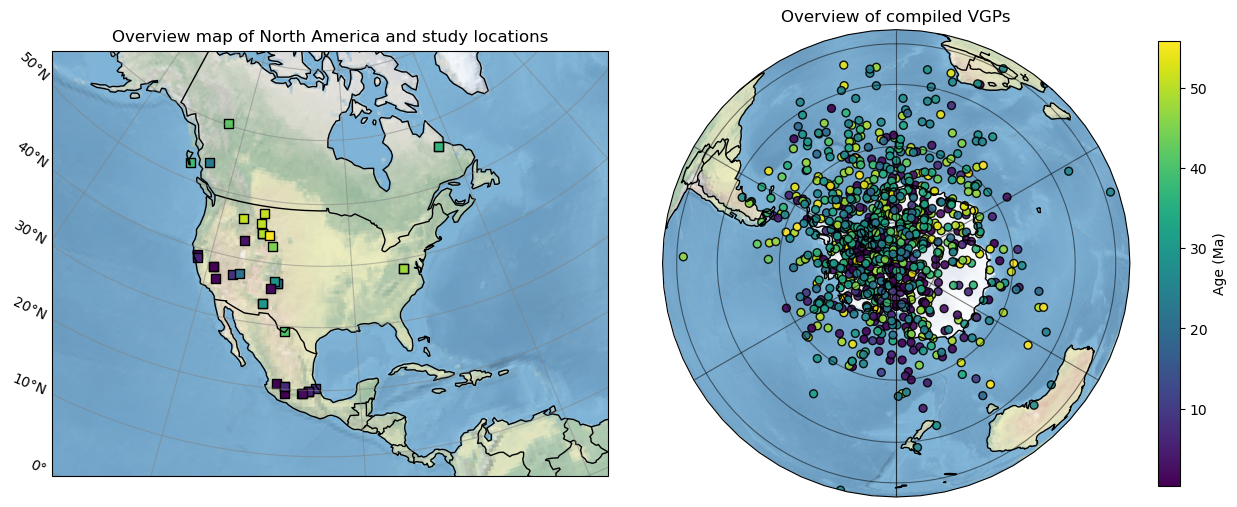

In [9]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
proj1 = ccrs.LambertConformal()

plt.figure(figsize=(12,10))

ax1 = plt.subplot(2, 2, 1, projection = proj1)
ax1.patch.set_visible(False)
ax1.set_extent([-135, -55, 5, 68], ccrs.Geodetic())
ax1.add_feature(cfeature.BORDERS)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='gray', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
ax1.stock_img()


plt.title('Overview map of North America and study locations')
s = plt.scatter(
    df_pole_compilation.slon,
    df_pole_compilation.slat,
    c = df_pole_compilation.mean_age,
    edgecolors= "black", marker = "s", s=42, alpha = 1, 
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)
plt.tight_layout()


ax2 = plt.subplot(2, 2, 2, projection=proj)
ax2.set_title('Overview of compiled VGPs')
ax2.add_feature(cfeature.BORDERS)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.8, color='black', alpha=0.5, linestyle='-')
gl.ylabels_left = True
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)
ax2.stock_img()

plt.title('Overview of compiled VGPs')
plt.scatter(
    df_filtered.vgp_lon_SH,
    df_filtered.vgp_lat_SH,
    c = df_filtered.mean_age,
    edgecolors= "black", marker = "o", s = 32, alpha =0.9,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)
plt.tight_layout()

plt.colorbar(s, fraction=0.04, alpha = 1).set_label("Age (Ma)")
# plt.savefig(os.path.join(current_path, '..')  + '/figures/1/1_AB.svg', dpi =600, bbox_inches='tight')

### Age distribution of VGPs

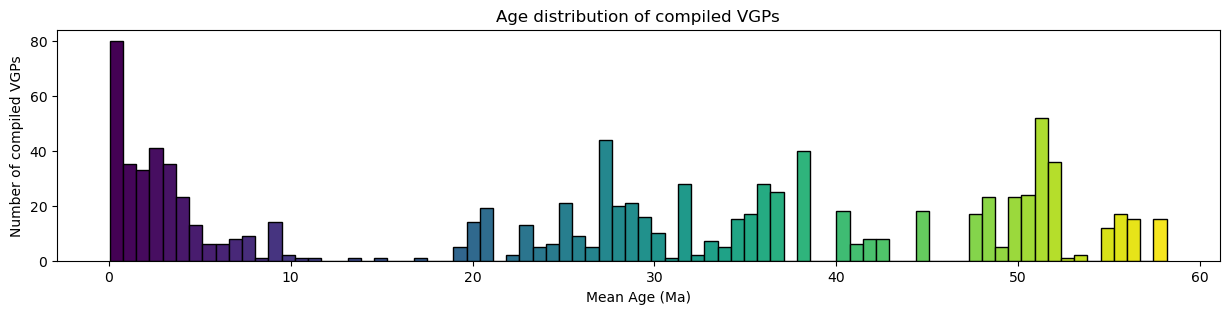

In [11]:
fig = plt.figure(figsize=(15,3))
plt.title('Age distribution of compiled VGPs')
plt.ylabel('Number of compiled VGPs')
plt.xlabel('Mean Age (Ma)')
# Data in numpy array
data = df_filtered['mean_age'].to_numpy()
 
cm = plt.cm.viridis
 
n, bins, patches = plt.hist(data, 80, color='green',edgecolor='black')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/80)) # notice the i/25

    
    
# os.path.join(current_path, '..')    
    
plt.savefig(os.path.join(current_path, '..')  + '/figures/1/1_C.svg', dpi =600, bbox_inches='tight')
plt.show()